# Projeto de Detecção de Objetos com YOLOv5 e COCO Dataset

Este notebook demonstra o processo de configuração, preparação de dados, treinamento e detecção de objetos usando o modelo YOLOv5 e um subconjunto personalizado do COCO Dataset.

**Etapas Principais:**

1.  **Configuração do Ambiente:** Clonagem do repositório YOLOv5 e instalação de dependências.
2.  **Preparação do Dataset:** Download de anotações do COCO, seleção de classes, download de imagens e criação de arquivos de anotação no formato YOLO.
3.  **Configuração do Treinamento:** Criação do arquivo `dataset.yaml` com os caminhos para os dados.
4.  **Treinamento do Modelo:** Execução do script de treinamento do YOLOv5.
5.  **Detecção de Objetos:** Utilização do modelo treinado (ou pré-treinado) para detectar objetos em uma imagem.
6.  **Visualização dos Resultados:** Exibição da imagem com as caixas de detecção.

---

## 1. Configuração do Ambiente

Esta seção configura o ambiente necessário para executar o YOLOv5, incluindo a clonagem do repositório e a instalação das bibliotecas e dependências.

In [14]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

!pip install -r requirements.txt

!pip install pycocotools

Cloning into 'yolov5'...
remote: Enumerating objects: 17564, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 17564 (delta 33), reused 7 (delta 7), pack-reused 17509 (from 3)
Receiving objects: 100% (17564/17564), 16.69 MiB | 23.87 MiB/s, done.
Resolving deltas: 100% (12031/12031), done.
/content/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5


## 2. Preparação do Dataset

Esta seção lida com o download e a preparação dos dados do COCO Dataset para treinar o modelo em classes específicas. Isso inclui baixar as anotações, selecionar as imagens que contêm as classes desejadas e gerar os arquivos de anotação no formato que o YOLOv5 espera.

In [15]:
import torch
import os
import json
import requests
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
from pycocotools.coco import COCO

print("Por favor, faça upload da imagem que você deseja usar para detecção após o treinamento.")
uploaded = files.upload()

os.environ["WANDB_MODE"] = "dryrun"

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip

COCO_file = "annotations/instances_train2017.json"
coco = COCO(COCO_file)

!wget -O yolov5s.pt https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s.pt

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')


classes_escolhidas = ["potted plant"]

categoria_ids = coco.getCatIds(catNms=classes_escolhidas)

image_ids = []
for cat_id in categoria_ids:
    image_ids.extend(coco.getImgIds(catIds=cat_id))
image_ids = list(set(image_ids))

image_dir = "coco_custom_dataset/images"
os.makedirs(image_dir, exist_ok=True)

print(f"Baixando {min(100, len(image_ids))} imagens...")
for img_id in image_ids[:100]:
    img_info = coco.loadImgs(img_id)[0]
    img_url = img_info['coco_url']
    img_name = os.path.join(image_dir, f"{img_id}.jpg")

    response = requests.get(img_url, stream=True)
    if response.status_code == 200:
        with open(img_name, 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
    else:
        print(f"Erro ao baixar a imagem {img_url}: Status Code {response.status_code}")


label_dir = "coco_custom_dataset/labels"
os.makedirs(label_dir, exist_ok=True)

with open(COCO_file, 'r') as f:
    coco_data = json.load(f)


class_map = {cat["name"]: cat["id"] for cat in coco_data["categories"]}
id_to_class_map = {cat["id"]: cat["name"] for cat in coco_data["categories"]}


print("Gerando arquivos de anotação no formato YOLO...")
for img_id in image_ids[:100]:
    img_info = coco.loadImgs(img_id)[0]
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=categoria_ids, iscrowd=False)
    anns = coco.loadAnns(ann_ids)

    label_file = os.path.join(label_dir, f"{img_id}.txt")
    with open(label_file, 'w') as f:
        for ann in anns:
            bbox = ann["bbox"]
            img_width = img_info['width']
            img_height = img_info['height']

            x_center = (bbox[0] + bbox[2] / 2) / img_width
            y_center = (bbox[1] + bbox[3] / 2) / img_height
            width = bbox[2] / img_width
            height = bbox[3] / img_height


            class_name = id_to_class_map.get(ann["category_id"])

            if class_name in classes_escolhidas:

                class_id_chosen = classes_escolhidas.index(class_name)
                f.write(f"{class_id_chosen} {x_center} {y_center} {width} {height}\n")
            else:

                print(f"Aviso: Anotação com category_id {ann['category_id']} ({class_name}) não está nas classes escolhidas. Ignorando.")

print("Geração de arquivos de anotação concluída.")

print(f"\nVerificando conteúdo do diretório de imagens: {abs_image_dir}")
image_files = os.listdir(abs_image_dir)
print(f"Número de arquivos encontrados: {len(image_files)}")
if len(image_files) > 0:
    print("Primeiros 5 arquivos:", image_files[:5])
else:
    print("Nenhum arquivo encontrado no diretório de imagens.")

print(f"\nVerificando conteúdo do diretório de anotações: {abs_label_dir}")
label_files = os.listdir(abs_label_dir)
print(f"Número de arquivos encontrados: {len(label_files)}")
if len(label_files) > 0:
    print("Primeiros 5 arquivos:", label_files[:5])
else:
    print("Nenhum arquivo encontrado no diretório de anotações.")

Por favor, faça upload da imagem que você deseja usar para detecção após o treinamento.


Saving Imagem do WhatsApp de 2025-01-30 à(s) 12.51.45_0d3a156c.jpg to Imagem do WhatsApp de 2025-01-30 à(s) 12.51.45_0d3a156c.jpg
--2025-08-29 02:50:15--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.195.17, 52.217.237.1, 52.217.116.1, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.195.17|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  36.6MB/s    in 6.6s    

2025-08-29 02:50:22 (36.6 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

loading annotations into memory...
Done (t=16.99s)
creating index...
index created!
--2025-08-29 02:51:13--  https://github.com/ultralytics/yolov5/releases/download/v7.0/yolov5s.pt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-8-29 Python-3.12.11 torch-2.8.0+cu126 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Baixando 100 imagens...
Gerando arquivos de anotação no formato YOLO...
Geração de arquivos de anotação concluída.

Verificando conteúdo do diretório de imagens: /content/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/coco_custom_dataset/images
Número de arquivos encontrados: 100
Primeiros 5 arquivos: ['90140.jpg', '360548.jpg', '327768.jpg', '352399.jpg', '147538.jpg']

Verificando conteúdo do diretório de anotações: /content/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/coco_custom_dataset/labels
Número de arquivos encontrados: 100
Primeiros 5 arquivos: ['172057.txt', '180351.txt', '32868.txt', '57500.txt', '180350.txt']


## 3. Configuração do Treinamento

Criação do arquivo `dataset.yaml` que informa ao YOLOv5 onde encontrar os dados de treinamento e validação, o número de classes e os nomes das classes.

In [16]:
current_dir = os.getcwd()
abs_image_dir = os.path.join(current_dir, image_dir)
abs_label_dir = os.path.join(current_dir, label_dir)

dataset_yaml = f"""\
train: {abs_image_dir}
val: {abs_image_dir} # Usando o mesmo diretório para validação para este exemplo
nc: {len(classes_escolhidas)} # Número de classes
names: {classes_escolhidas} # Nomes das classes
"""
with open("dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print(f"\nConteúdo do dataset.yaml:\n{dataset_yaml}")


Conteúdo do dataset.yaml:
train: /content/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/coco_custom_dataset/images
val: /content/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/coco_custom_dataset/images # Usando o mesmo diretório para validação para este exemplo
nc: 1 # Número de classes
names: ['potted plant'] # Nomes das classes



## 4. Treinamento do Modelo

Execução do script `train.py` do YOLOv5 para treinar o modelo nos dados personalizados. Estamos usando os pesos pré-treinados `yolov5s.pt` como ponto de partida.

In [17]:
print("\nIniciando treinamento...")

os.makedirs('runs/train/exp/weights', exist_ok=True)
!python train.py --img 640 --batch 16 --epochs 1 --data dataset.yaml --weights yolov5s.pt --nosave-txt --nosave-hybrid --project runs/train --name exp # 1 época, adicionando flags de não salvar e especificando projeto/nome

print("\nVerificando diretórios de saída do treinamento...")
print(f"Diretório atual: {os.getcwd()}")
print("Conteúdo de ./runs/train/:")
!ls ./runs/train/
print("\nConteúdo de ./runs/train/exp/weights/ (se existir):")
!ls ./runs/train/exp/weights/ 2>/dev/null || echo "Diretório ./runs/train/exp/weights/ não encontrado ou vazio."



Iniciando treinamento...
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-08-29 02:59:06.345380: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756436346.809800   32382 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756436346.940500   32382 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756436347.973570   32382 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756436347.977560   32382 computation_placer.cc:177] computatio

## 5. Detecção de Objetos

Utiliza o script `detect.py` para executar a detecção de objetos na imagem que você carregou. Usaremos os pesos pré-treinados `yolov5s.pt` para esta detecção.

In [18]:

print("\nIniciando detecção (usando pesos pré-treinados)...")

image_path_for_detection = list(uploaded.keys())[0]
!python detect.py --weights yolov5s.pt --source "{image_path_for_detection}"


Iniciando detecção (usando pesos pré-treinados)...
detect: weights=['yolov5s.pt'], source=Imagem do WhatsApp de 2025-01-30 à(s) 12.51.45_0d3a156c.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-430-g459d8bf0 Python-3.12.11 torch-2.8.0+cu126 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 /content/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/yolov5/Imagem do WhatsApp de 2025-01-30 à(s) 12.51.45_0d3a156c.jpg: 480x640 17 persons, 2 bottles, 1 chair, 1 tv, 3 laptops, 1 keyboard, 332.5ms
Speed: 6.

## 6. Visualização dos Resultados

Carrega e exibe a imagem de saída gerada pelo script `detect.py`, que contém as caixas de detecção e os rótulos dos objetos encontrados.


Exibindo imagem de resultado da detecção de: runs/detect/exp/Imagem do WhatsApp de 2025-01-30 à(s) 12.51.45_0d3a156c.jpg


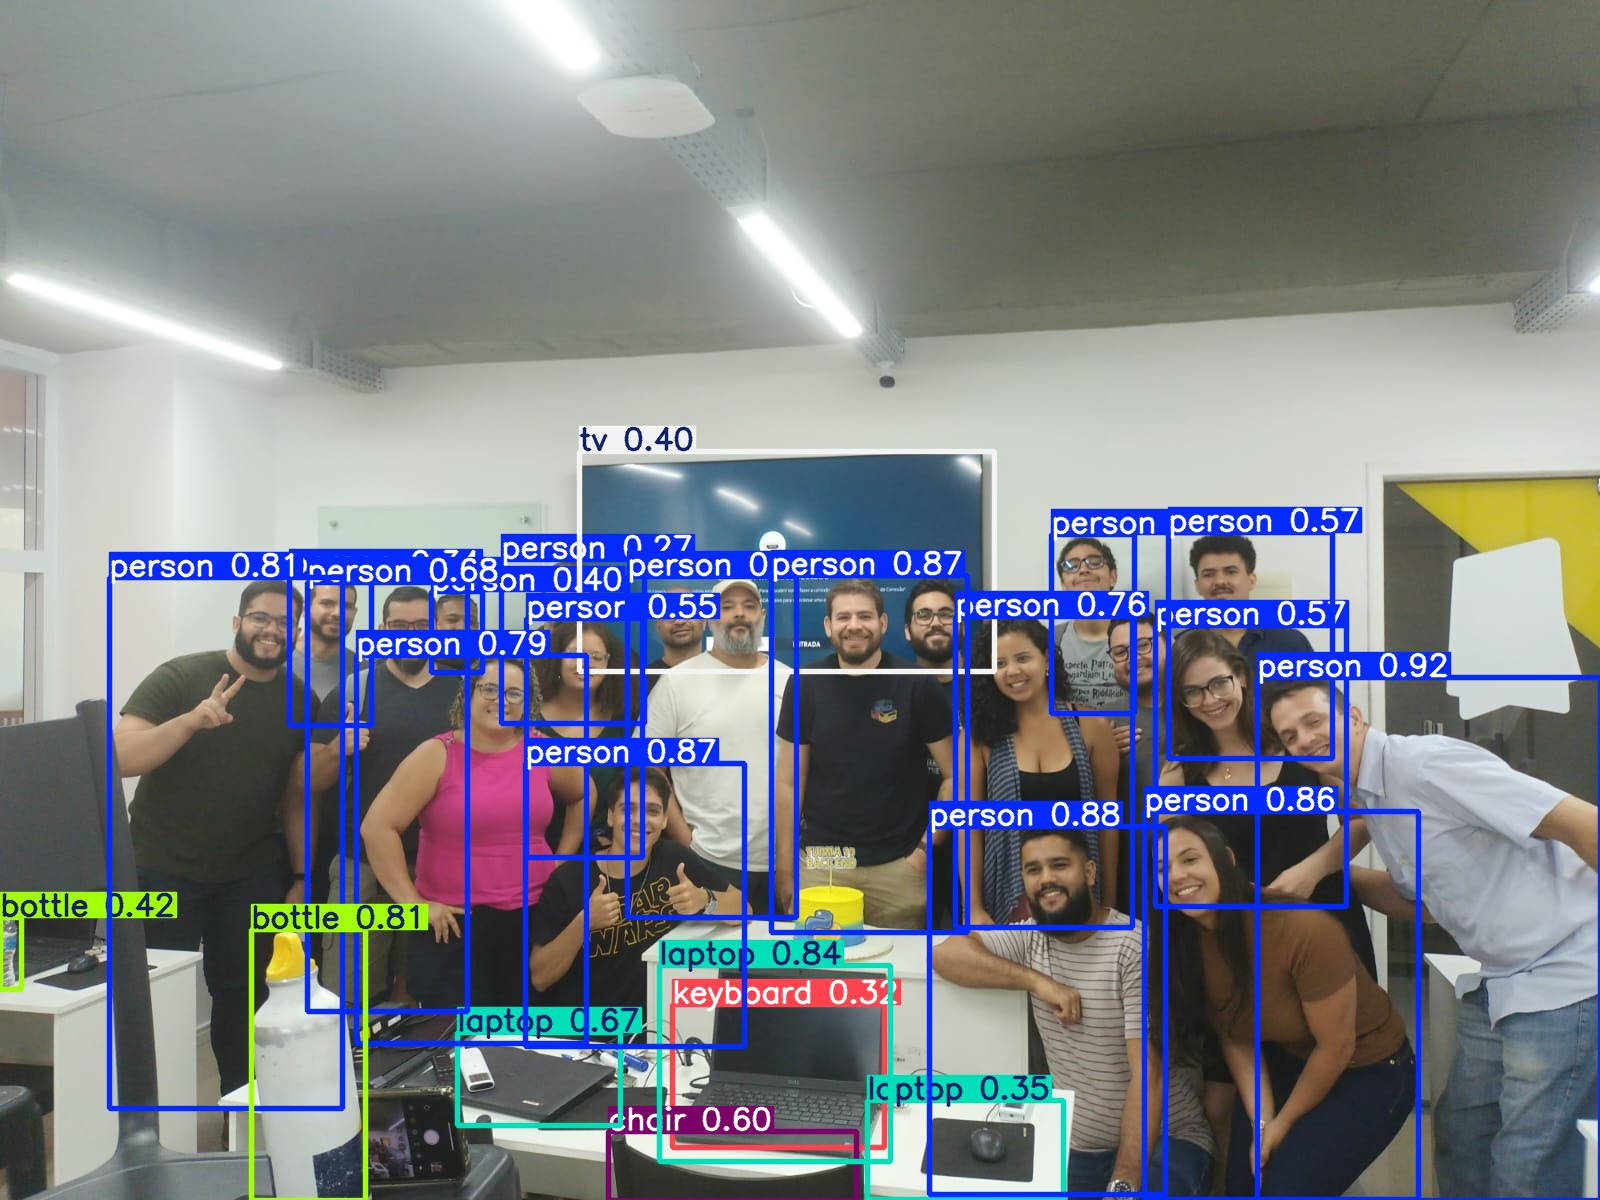

In [25]:
import os
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image, display

detect_output_base_dir = 'runs/detect'
detect_runs = [d for d in os.listdir(detect_output_base_dir) if os.path.isdir(os.path.join(detect_output_base_dir, d))]
detect_runs.sort(key=lambda x: os.path.getmtime(os.path.join(detect_output_base_dir, x)), reverse=True)

output_image_path = None
if detect_runs:
    latest_detect_run_dir = os.path.join(detect_output_base_dir, detect_runs[0])
    original_image_name = list(uploaded.keys())[0]
    output_image_name_base = os.path.basename(original_image_name)


    for root, _, files in os.walk(latest_detect_run_dir):
        for file in files:
            if file == output_image_name_base:
                output_image_path = os.path.join(root, file)
                break
        if output_image_path:
            break

if output_image_path and os.path.exists(output_image_path):
    print(f"\nExibindo imagem de resultado da detecção de: {output_image_path}")
    display(Image(filename=output_image_path))

else:
    print(f"Arquivo de imagem de resultado não encontrado no diretório de saída da detecção: {output_image_name_base}")
    if detect_runs:
        print(f"Verificado no diretório: {latest_detect_run_dir}")
        print(f"Conteúdo do diretório {latest_detect_run_dir}: {os.listdir(latest_detect_run_dir)}")
    else:
        print(f"Nenhum diretório de saída de detecção encontrado em {detect_output_base_dir}")